# Geometric phase of Gravitational waves with several levels of precession

In [14]:
import quaternion
import numpy as np
import matplotlib.pyplot as plt
import bispy as bsp
import pygeomphase as pgp
import scipy as scp
import palettable as pal
from matplotlib.gridspec import GridSpec

# stuff for 3D plotting
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.patches import FancyArrowPatch
from mpl_toolkits.mplot3d import proj3d
from matplotlib.colors import LightSource

%matplotlib ipympl

class Arrow3D(FancyArrowPatch):

    def __init__(self, x, y, z, dx, dy, dz, *args, **kwargs):
        super().__init__((0, 0), (0, 0), *args, **kwargs)
        self._xyz = (x, y, z)
        self._dxdydz = (dx, dy, dz)

    def draw(self, renderer):
        x1, y1, z1 = self._xyz
        dx, dy, dz = self._dxdydz
        x2, y2, z2 = (x1 + dx, y1 + dy, z1 + dz)

        xs, ys, zs = proj3d.proj_transform((x1, x2), (y1, y2), (z1, z2), self.axes.M)
        self.set_positions((xs[0], ys[0]), (xs[1], ys[1]))
        super().draw(renderer)
        
    def do_3d_projection(self, renderer=None):
        x1, y1, z1 = self._xyz
        dx, dy, dz = self._dxdydz
        x2, y2, z2 = (x1 + dx, y1 + dy, z1 + dz)

        xs, ys, zs = proj3d.proj_transform((x1, x2), (y1, y2), (z1, z2), self.axes.M)
        self.set_positions((xs[0], ys[0]), (xs[1], ys[1]))

        return np.min(zs) 


def _arrow3D(ax, x, y, z, dx, dy, dz, *args, **kwargs):
    '''Add an 3d arrow to an `Axes3D` instance.'''

    arrow = Arrow3D(x, y, z, dx, dy, dz, *args, **kwargs)
    ax.add_artist(arrow)


setattr(Axes3D, 'arrow3D', _arrow3D)

In [15]:
path2data = '../../StageM2/data/'
Data = np.load(path2data + 'data_precession_OG_Pancharatnam.npz')

In [16]:
# Waveform selection 
# 1 = low precession  --- 4 = high precession

hp = Data['hp4']
hc = Data['hc4']
time = Data['time4']
# Normalization (otherwise we have 10^-19 terms)

hp = hp/np.max(hp)
hc = hc/np.max(hc)

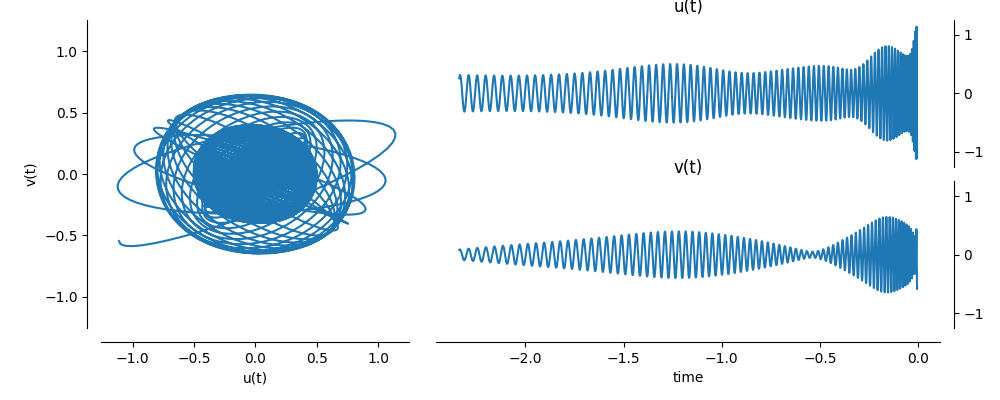

In [17]:
h1 = hp + 1j*scp.signal.hilbert(hp)
h2 = hc + 1j*scp.signal.hilbert(hc)

# Choice of the last N samples to consider (untill merger)
N = 20000
M = 900
hq = bsp.utils.sympSynth(h1[-N:-M],h2[-N:-M])
tN = time[-N:-M]
bsp.utils.visual.plot2D(tN, hq);

### Compute some useful quantities

In [18]:
a, theta, chi, phi = bsp.utils.quat2euler(hq)
S0, S1, S2, S3 = bsp.utils.geo2Stokes(a, theta, chi)
x1, x2 = bsp.utils.sympSplit(hq)

## Compute the geometric phase with an "old" function.
#### (there seems to be a problem with the pygeom function)

In [19]:
# Fonction de calcul la phase geo
  
def phases(xq):
    
    u, v = bsp.utils.sympSplit(xq)
    N = xq.shape[0]
    xc = np.vstack((u, v))

    PhiRel = np.zeros(N)
    PhiTot = np.zeros(N)

    for n in range(1, N):
        PhiTot[n] = PhiTot[n-1] + np.angle(xc[:, n-1].T.conj() @ xc[:, n])
        PhiRel[n] = np.angle(xc[:, 0].T.conj() @ xc[:, n])
        
    return PhiTot, PhiRel

phitot1, phirel1 = phases(hq)

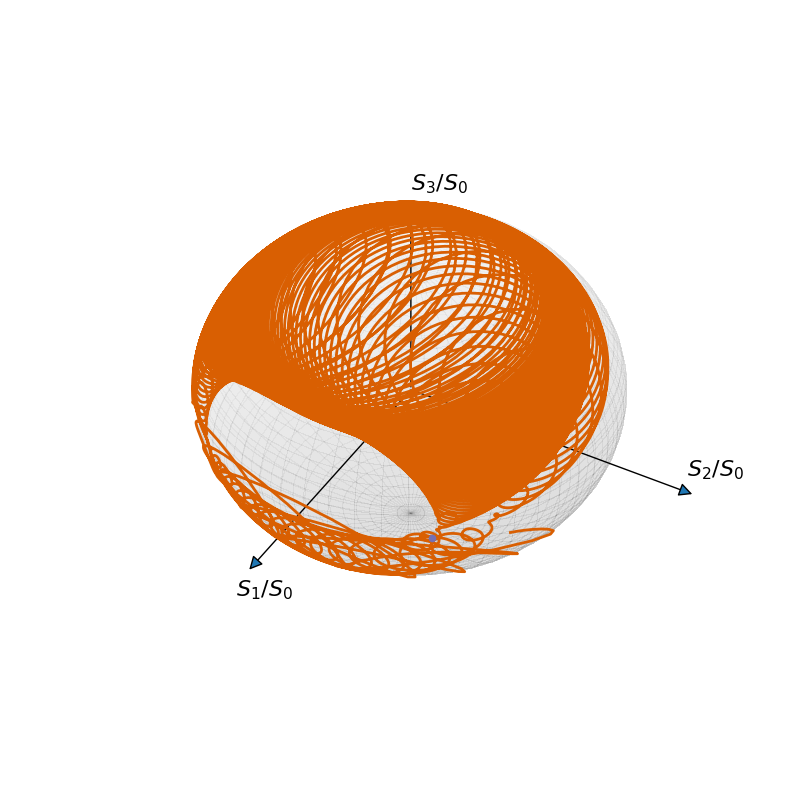

In [20]:
cmap = pal.colorbrewer.qualitative.Dark2_8.mpl_colors

labelsize=16
# Poincare sphere representation
fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(111, projection='3d', computed_zorder=False)

u, v = np.mgrid[0:2*np.pi:50j, 0:np.pi:50j]
x = np.cos(u)*np.sin(v)
y = np.sin(u)*np.sin(v)
z = np.cos(v)

r = 0.99
ls = LightSource(azdeg=210, altdeg=30)
ax.plot_surface(r*x, r*y, r*z, color=(0.9, 0.9, 0.9), alpha=.1, zorder=-1, rstride=1, cstride=1, \
                linewidth=0, antialiased=False)


arrow_prop_dict = dict(mutation_scale=20, arrowstyle='->', shrinkA=0, shrinkB=0)

ax.arrow3D(0,0,0,
           1.5,0,0,
           mutation_scale=20,
           arrowstyle="-|>")
ax.arrow3D(0,0,0,
           0,1.5,0,
           mutation_scale=20,
           arrowstyle="-|>")

ax.arrow3D(0,0,0,
           0,0,1.5,
           mutation_scale=20,
           arrowstyle="-|>")



ax.scatter(0,0,0, zorder=1, marker='s', color='gray', s=4)

ax.plot(S1/S0, S2/S0, S3/S0, color=cmap[1], zorder=1, linewidth=2)
ax.scatter((S1/S0)[0], (S2/S0)[0], (S3/S0)[0], color=cmap[2], zorder=1)
#ax.scatter((S1/S0)[-1], (S2/S0)[-1], (S3/S0)[-1], color='red', marker='s', zorder=7)

ax.text(1.6, 0, -0.1, r'$S_1/S_0$', fontsize=labelsize)
ax.text(-0.1, 1.4, 0, r'$S_2/S_0$', fontsize=labelsize)
ax.text(0, 0, 1.6, r'$S_3/S_0$', fontsize=labelsize, )

ax.grid(False)
ax.set_axis_off()
ax.view_init(azim=30, elev=40)

ax.set_proj_type('ortho')
fig.tight_layout()
#fig.savefig('GWPoincaresphere4.jpg', dpi=600)

## Geometric phase with other function

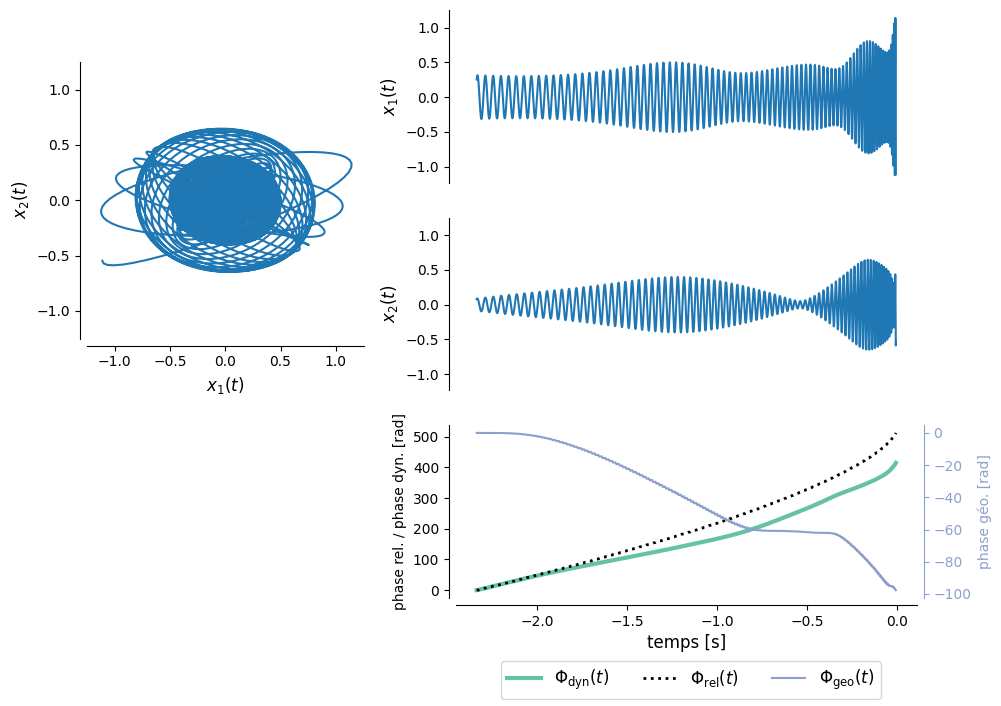

In [216]:
cmap = pal.colorbrewer.qualitative.Set2_3.mpl_colors

def adjust_spines(ax, spines):
    for loc, spine in ax.spines.items():
        if loc in spines:
            spine.set_position(('outward', 5))  # outward by 10 points
        else:
            spine.set_color('none')  # don't draw spine

    # turn off ticks where there is no spine
    if 'left' in spines:
        ax.yaxis.set_ticks_position('left')
    else:
        # no yaxis ticks
        ax.yaxis.set_ticks([])

    if 'bottom' in spines:
        ax.xaxis.set_ticks_position('bottom')
    else:
        # no xaxis ticks
        ax.xaxis.set_ticks([])
        
labelsize=12
fig = plt.figure(figsize=(10, 7))

gs = GridSpec(3, 5, figure=fig, hspace=0.2,wspace=1, top=0.99, bottom=0.15, right=0.93, left=0.1)
ax1 = fig.add_subplot(gs[:2, :2])
ax2 = fig.add_subplot(gs[0, 2:])
ax3 = fig.add_subplot(gs[1, 2:], sharey =ax2)
ax4 = fig.add_subplot(gs[2, 2:])

# ax1

ax1.plot(x1.real, x2.real)
# ax2 

ax2.plot(tN, x1.real)

# ax3
ax3.plot(tN, x2.real, zorder=0)

#ax4 
ax4.plot(tN, phitot1,  label=r'$\Phi_{\mathrm{dyn}}(t)$', color=cmap[0], linewidth=3)
ax4.plot(tN, np.unwrap(phirel1), label=r'$\Phi_{\mathrm{rel}}(t)$', color='k', linewidth=2, linestyle='dotted')


ax4bis = ax4.twinx()
p2, = ax4bis.plot(tN, phitot1 - np.unwrap(phirel1), color=cmap[2], label=r'$\Phi_{\mathrm{geo}}(t)$')

# graphic stuff 

ax1.set_xlim(-1.25, 1.25)
ax1.set_ylim(-1.25, 1.25)

ax1.set_xticks([-1, -0.5, 0, 0.5, 1])
ax1.set_yticks([-1, -0.5, 0, 0.5, 1])

ax1.spines['top'].set_visible(False)
ax1.spines['right'].set_visible(False)
ax1.spines['left'].set_position(('outward', 5))
ax1.spines['bottom'].set_position(('outward', 5))
adjust_spines(ax2, ['left'])
adjust_spines(ax3, ['left'])
adjust_spines(ax4, ['left', 'bottom'])
ax4bis.spines['top'].set_visible(False)
ax4bis.spines['left'].set_visible(False)
ax4bis.spines['bottom'].set_visible(False)
ax4bis.spines['right'].set_position(('outward', 5))


#


ax1.set_xlabel(r'$x_1(t)$', fontsize=labelsize)
ax1.set_ylabel(r'$x_2(t)$', fontsize=labelsize)

ax2.set_ylabel(r'$x_1(t)$', fontsize=labelsize)
ax3.set_ylabel(r'$x_2(t)$', fontsize=labelsize)

ax4.set_xlabel('temps [s]', fontsize=labelsize)
ax4bis.set_ylabel('phase géo. [rad]')
ax4.set_ylabel(r'phase rel. / phase dyn. [rad]')

fig.legend(ncol=3, loc=(0.5, 0.01), fontsize=12, frameon=True)
# colors
ax4bis.yaxis.label.set_color(p2.get_color())
ax4bis.tick_params(axis='y', colors=p2.get_color())
ax4bis.spines['right'].set_color(p2.get_color())

# fixes
ax1.set_box_aspect(1)

#plt.savefig('exp1.pdf')
